### Clouds : test clouds 2D with NEXT MC events

G. Díaz, J. A Hernando


May 2021

In [1]:
%matplotlib inline 
#notebook
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

import clouds.clouds    as clouds
import clouds.pltclouds as pltclouds

#import bes.bes           as bes
#import bes.clouds        as clouds
#import next.reco.chits      as chits
#import next.reco.display    as nplay


In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Tue May  4 18:33:27 2021


In [5]:
#import os
import re
import glob
#import numpy  as np
#import pandas as pd
#import tables as tb

#import matplotlib
#from matplotlib import cm
#from matplotlib import pyplot as plt

#import clouds
#import pltclouds

In [6]:
get_file_number = lambda filename: int(re.findall("_[0-9]+_", filename)[0][1:-1])

def split_hits(hitsdf, weight="E"):
    
    xyz = hitsdf[["X", "Y", "Z"]].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    w = hitsdf[weight].values
    
    return x, y, z, w

# ojo
#fname = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/map_8264.h5'
fname = '/Users/hernando/investigacion/NEXT/data/MC/NEW/bb0nu_esmeralda/map_8264.h5'
maps_te = pd.read_hdf(fname, "time_evolution")
dv = maps_te.dv.mean()

In [7]:
#datadir   = "/home/hernando/data/NEW/MC/bb0nu_esmeralda/"
datadir   = "/Users/hernando/investigacion/NEXT/data/MC/NEW/bb0nu_esmeralda/"
files     = glob.glob(datadir + '*.h5')
def file_number(file):
    fname = file .split('/')[-1]
    ifile = fname.split('_')[1]
    return str(ifile)
#print(files)
filenames = sorted(files, key = file_number)
print('total files', len(filenames))

total files 501


In [8]:
#filename = np.random.choice(filenames)
#print(filename)
#filename = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/esmeralda_321_0nubb.h5'
#print("File number", get_file_number(filename))

In [9]:
filename = np.random.choice(filenames)

CHITS_lowTh  = pd.read_hdf(filename, "/CHITS/lowTh") .groupby("event")
CHITS_highTh = pd.read_hdf(filename, "/CHITS/highTh").groupby("event")

MChits = pd.read_hdf(filename, "MC/hits").groupby("event_id")
data_events = pd.read_hdf(filename, "Run/events")


In [98]:
event = np.random.choice(data_events["evt_number"])
print("File number", get_file_number(filename), ", Event", event)
# events good:  3214

File number 177 , Event 1777


In [99]:
low  = CHITS_lowTh .get_group(event)
high = CHITS_highTh.get_group(event)
true = MChits      .get_group(event)

x, y, z, w = split_hits(low, weight="E")
coors = (x, y, z)
ene   = 1e-5 * w
steps = (10., 10., 2.)

xmc, ymc, zmc = true["x"].values, true["y"].values, dv*true["z"].values
enemc, timemc = true["energy"].values, true['time'].values
coorsmc = (xmc, ymc, zmc)

print('Energy MC ', np.sum(enemc), ', RC ', np.sum(ene))

Energy MC  2.4578302 , RC  2.39273584309578


## Draw MC event

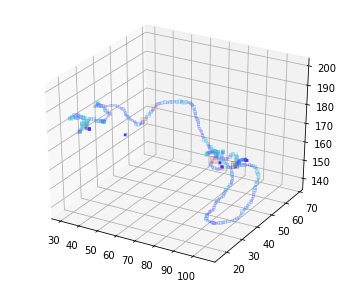

In [112]:
subplot = pltext.canvas(1, 1)
plt.gcf().add_subplot(1, 1 ,1, projection = '3d')
scalemc = enemc/np.max(enemc)
plt.gca().scatter(xmc, ymc, zmc, c = scalemc , s = 50 * scalemc, marker = 's', alpha = 0.2);
plt.show()

In [113]:
def plot_tview(cells, ene, t, tname = 't'):
    ndim = len(cells)
    subplot = pltext.canvas(ndim+1, 2, 4, 4)
    subplot(1)
    plt.gca().scatter(t, ene);
    plt.xlabel(tname); plt.ylabel('ene')
    
    xname = ['x', 'y', 'z']
    scale = ene/np.max(ene)
    for i in range(ndim):
        subplot(2 + i)
        x  = cells[i]
        plt.gca().scatter(t, x, c = scale, s = 10);
        plt.grid();
        plt.xlabel(tname); plt.ylabel(xname[i])

    plt.tight_layout()
    plt.show()
    return


def plot_xyview(cells, ene, mccells = None, mcene = None):
    
    ndim = len(cells)
    subplot = pltext.canvas(4, 2, 4, 4)
    
    
    def _plot(cells, ene, cmap = 'rainbow'):
        
        cscale = ene/np.max(ene)
        sdim = '3d' if ndim == 3 else ''
        subplot(1, sdim)
        plt.gca().scatter(*cells, c = cscale)
    
        xname = ['x', 'y', 'z']
        for i in range(ndim):
            j = 0 if i == ndim - 1 else i + 1
            subplot(2 + i, '2d')
            plt.gca().scatter(cells[i], cells[j], c = cscale, s = 10, cmap = cmap)
            plt.grid();
            plt.xlabel(xname[i]); plt.ylabel(xname[j])
            
    _plot(cells, ene)
    if (mcene is not None):
        _plot(mccells, mcene, cmap = 'gray')
    
    plt.tight_layout();
    return

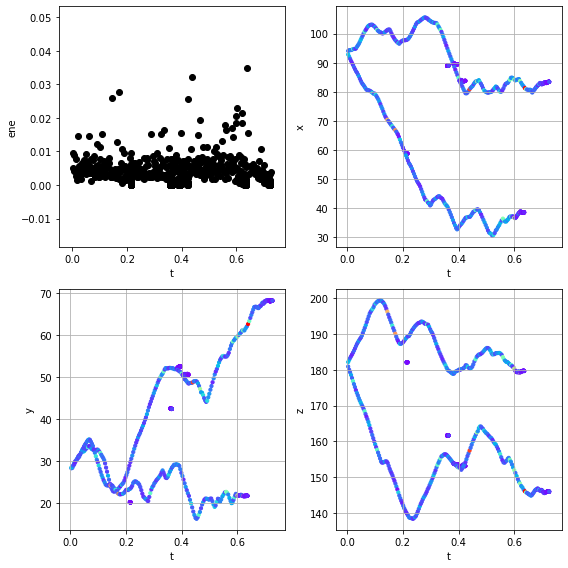

In [114]:
plot_tview(coorsmc, enemc, timemc)

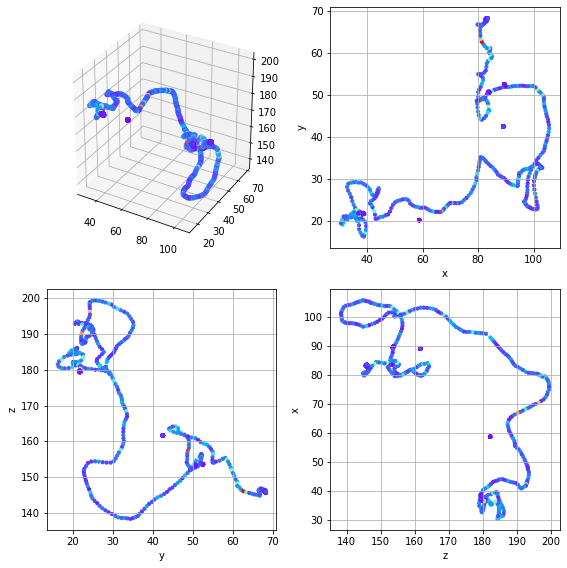

In [115]:
plot_xyview(coorsmc, enemc)

## Draw Reco

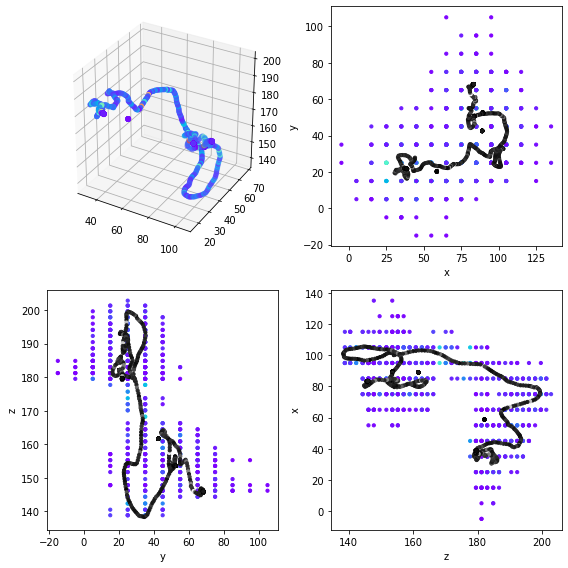

In [116]:
plot_xyview(coors, ene, coorsmc, enemc)

## Clouds 

### x, y proyection

In [117]:
def _ana(coors, steps, ene, mccoors, mcene, labels, cut = 0):
    bins, mask, cells, df = clouds.clouds(coors, steps, ene, cut)
    
    scalemc = mcene/np.max(mcene)
    plt.figure(figsize = (2 * 6, 1 * 5))
    plt.subplot(1, 2, 1)
    pdraw = pltclouds.drawer(bins, cells, df, 'e', False)
    pdraw(value = False, isdisper = True)
    plt.scatter(*mccoors, c = scalemc, marker = '.', alpha = 0.5);
    plt.xlabel(labels[0]); plt.ylabel(labels[1])
    plt.title('gradient')

    plt.subplot(1, 2, 2)
    pdraw = pltclouds.drawer(bins, cells, df, 'p', False)
    pdraw(value = False, isdisper = True)
    plt.scatter(*mccoors, c = scalemc, marker = '.', alpha = 0.5);
    plt.xlabel(labels[0]); plt.ylabel(labels[1])
    plt.title('laplacian')
    
    return

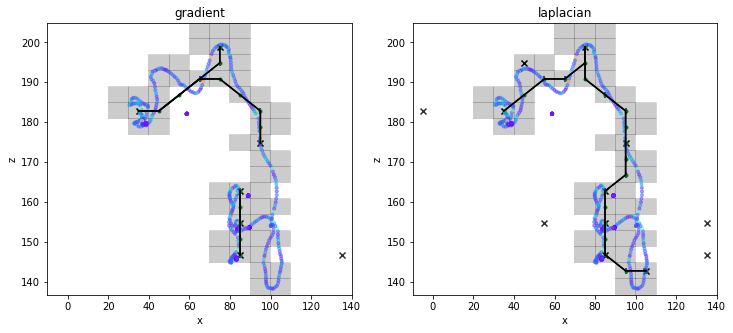

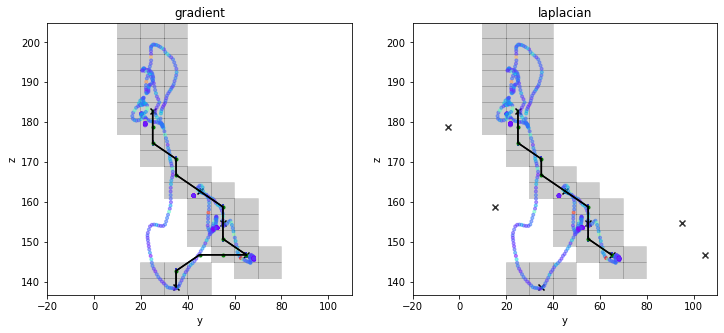

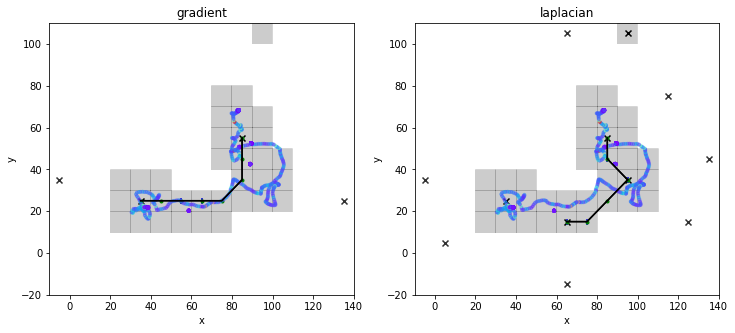

In [118]:
cut = 0
_ana((x, z), (10.,  4.), ene, (xmc, zmc), enemc, ('x', 'z'), cut)
_ana((y, z), (10.,  4.), ene, (ymc, zmc), enemc, ('y', 'z'), cut)
_ana((x, y), (10., 10.), ene, (xmc, ymc), enemc, ('x', 'y'), cut)